<a href="https://colab.research.google.com/github/xxx0708/CNN/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt


import os
import json
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [25]:
# 设置transforms
transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(), # numpy -> Tensor
                                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) # 归一化，范围[-1, 1]
])

In [26]:
# 下载数据集
# 训练集
trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
# 测试集
testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# 批量读取数据
from torch.utils.data.dataloader import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)

test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 224, 224])
torch.Size([128])


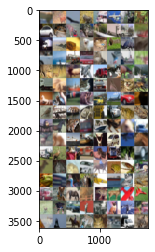

 deer  deer  bird  frog  ship plane horse  deer   car   dog   dog  frog   dog truck truck  ship truck plane  frog   dog   cat   dog  bird   cat   car plane truck   car   cat plane  ship  bird  frog  deer  deer plane truck   cat horse  ship truck   dog  ship   cat   car  bird   cat horse horse   dog plane  frog truck plane   car   cat  bird plane  ship   cat truck truck  frog  frog plane horse  frog truck  ship   dog horse truck  deer  deer  ship  ship  bird   car plane horse truck  deer   cat truck   cat truck horse   car  deer   cat   cat   car horse  frog  bird   dog  frog truck  bird   cat plane  ship   cat  frog truck   dog horse horse  frog  deer plane plane  deer   dog   car   cat truck   cat plane truck  bird  bird horse   dog  frog  ship truck   cat


In [28]:
# 可视化显示
import matplotlib.pyplot as plt
import numpy as np

# 10个类别
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # 逆正则化
    np_img = img.numpy() # tensor --> numpy
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # 改变通道顺序
    plt.show()
    
# 随机获取一批数据
imgs, labs = next(iter(train_loader))

print(imgs.shape)
print(labs.shape)

# 调用方法
imshow(torchvision.utils.make_grid(imgs))

# 输出这批图片对应的标签
print(' '.join('%5s' % classes[labs[i]] for i in range(BATCH_SIZE)))

In [29]:
# 定义网络模型

import torch.nn as nn
import torch.nn.functional as F

"""
1. 特征图尺寸的计算公式为：[(原图片尺寸 — 卷积核尺寸) / 步长 ] + 1
"""

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            #第一层
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # input[3, 224, 224]  output[48, 55, 55]
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),   # output[48, 27, 27]
            #第二层               
            nn.Conv2d(96, 256, kernel_size=5, padding=2),           # output[128, 27, 27]
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 13, 13]
            #第三层
            nn.Conv2d(256, 384, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            #第四层
            nn.Conv2d(384, 384, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            #第五层
            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # output[128, 13, 13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 6, 6]
        )
        self.classifier= nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )
    

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


In [30]:
# 创建模型
net = AlexNet().cuda()
print('Architecture:')
print(net)

Architecture:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=

In [31]:
# 定义优化器和损失函数
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 交叉式损失函数

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # 优化器

In [32]:
# 定义轮数
EPOCHS = 30
save_path = './AlexNet.pth'
best_acc = 0.0
train_steps = len(train_loader)
for epoch in range(EPOCHS):
    
    train_loss = 0.0
    for i, (datas, labels) in enumerate(train_loader):
        datas, labels = datas.cuda(), labels.cuda()
        # 梯度置零
        optimizer.zero_grad()
        # 训练
        outputs = net(datas)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # 累计损失
        train_loss += loss.item()
        
        
    # 打印信息
    print("Epoch :%d , Batch : %5d , Loss : %.3f"%(epoch+1, i+1, train_loss/len(train_loader.dataset)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch :1 , Batch :   391 , Loss : 0.018
Epoch :2 , Batch :   391 , Loss : 0.018
Epoch :3 , Batch :   391 , Loss : 0.016
Epoch :4 , Batch :   391 , Loss : 0.015
Epoch :5 , Batch :   391 , Loss : 0.014
Epoch :6 , Batch :   391 , Loss : 0.013
Epoch :7 , Batch :   391 , Loss : 0.013
Epoch :8 , Batch :   391 , Loss : 0.012
Epoch :9 , Batch :   391 , Loss : 0.011
Epoch :10 , Batch :   391 , Loss : 0.011
Epoch :11 , Batch :   391 , Loss : 0.010
Epoch :12 , Batch :   391 , Loss : 0.010
Epoch :13 , Batch :   391 , Loss : 0.010
Epoch :14 , Batch :   391 , Loss : 0.009
Epoch :15 , Batch :   391 , Loss : 0.009
Epoch :16 , Batch :   391 , Loss : 0.009
Epoch :17 , Batch :   391 , Loss : 0.009
Epoch :18 , Batch :   391 , Loss : 0.008
Epoch :19 , Batch :   391 , Loss : 0.008
Epoch :20 , Batch :   391 , Loss : 0.008
Epoch :21 , Batch :   391 , Loss : 0.008
Epoch :22 , Batch :   391 , Loss : 0.008
Epoch :23 , Batch :   391 , Loss : 0.007
Epoch :24 , Batch :   391 , Loss : 0.007
Epoch :25 , Batch :   391

In [33]:
# 保存模型
PATH = './cifar_net.pth'

torch.save(net.state_dict(), PATH)

In [34]:
# 加载模型

model = AlexNet()

model.load_state_dict(torch.load(PATH)) 

<All keys matched successfully>

In [35]:
# 测试
correct = 0
total = 0
with torch.no_grad():
    for i , (datas, labels) in enumerate(test_loader):
        # 输出
        outputs = model(datas) # outputs.data.shape --> torch.Size([128, 10])
        _, predicted = torch.max(outputs.data, dim=1) # 第一个是值的张量，第二个是序号的张量
        # 累计数据量
        total += labels.size(0)  # labels.size() --> torch.Size([128]) , labels.size(0) --> 128
        # 比较有多少个预测正确
        correct += (predicted == labels).sum() # 相同为1，不同为0，利用sum()求总和
        val_accurate = correct / total * 100
    print("在10000张测试集图片上的准确率：{:.3f}%".format(correct / total * 100))
    
    if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


在10000张测试集图片上的准确率：68.000%
Finished Training


In [36]:
#plt.title('val_accurate')
#plt.plot(itr, acc_hist_part, '-o')
#plt.xlabel('iterations')
#plt.ylabel('accuracy')
#plt.gcf().set_size_inches(9, 4)
#plt.show()